# **Chordal graphs coloring**

**What is a chord**

Given a cycle with vertices in order $v1, v2, ..., vk$, a chord is an edge ${vi, vj}$ where i and j are not consecutive in the cycle (and not the same vertex).

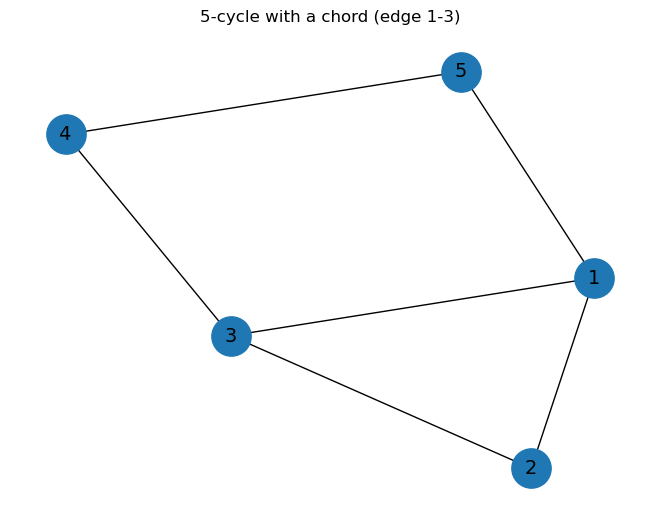

In [2]:
import networkx as nx
import matplotlib.pyplot as plt

G_base = nx.cycle_graph(5)
G_base = nx.relabel_nodes(G_base, {i: i+1 for i in G_base.nodes()})
G_base.add_edge(1, 3)

pos = nx.spring_layout(G_base, seed=42)

nx.draw(G_base, pos, with_labels=True, node_size=800, font_size=14)
plt.title("5-cycle with a chord (edge 1-3)")
plt.show()


**Chordal graph**

A graph is chordal when every cycle of length ≥ 4 has a chord. 

Equivalently, every induced (chordless) cycle in the graph should have exactly three vertices.

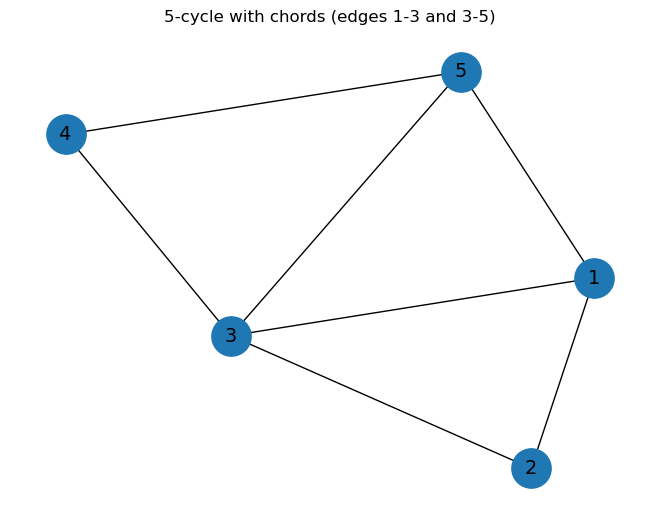

In [3]:
G2 = G_base.copy()
G2.add_edge(3, 5)

nx.draw(G2, pos, with_labels=True, node_size=800, font_size=14)
plt.title("5-cycle with chords (edges 1-3 and 3-5)")
plt.show()


**Why coloring chordal graphs is different.**

A proper vertex coloring assigns colors to vertices so that adjacent vertices have different colors. In general graphs, finding the minimum number of colors needed (the chromatic number χ(G)) is computationally difficult: for arbitrary graphs there is no known algorithm that is guaranteed to find an optimal coloring efficiently for all inputs. Because of this, simple methods such as greedy coloring can depend heavily on the chosen vertex order and may use more colors than necessary.

Chordal graphs have additional structure that makes optimal coloring efficient:

No long chordless cycles: the graph does not contain induced cycles of length ≥ 4. This restricts the ways “difficult” interactions between vertices can occur.

Clique number determines the answer: in chordal graphs, the minimum number of colors equals the size of the largest clique: $χ(G)=ω(G)$

(A clique is a set of vertices such that every pair of vertices in the set is connected by an edge.)

**Greedy coloring** becomes optimal with the right order: while greedy coloring can be suboptimal on general graphs, chordal graphs admit a special vertex ordering such that greedy coloring produces an optimal coloring.

**Perfect Elimination Ordering (PEO)**

The “special vertex ordering” used for chordal graphs is called a perfect elimination ordering.

**A graph is chordal if and only if it has a perfect elimination ordering.**

An ordering of the vertices $v1, v2, ..., vn$ is a PEO if it has the following property:

For each vertex $v$, the neighbors of $v$ that appear later in the ordering form a clique.

Intuitively, this means we can remove vertices one by one in this order, and at the moment we remove a vertex, its remaining neighbors are all mutually connected. Vertices with this property are often called simplicial (their neighborhood forms a clique in the remaining graph).

In [4]:
from typing import Dict, Hashable, List

def greedy_coloring(G: nx.Graph, order: List[Hashable]) -> Dict[Hashable, int]:
    """
    Greedy vertex coloring in the given vertex order.
    Returns a dict: vertex -> color (colors are 1,2,3,...).
    """
    color: Dict[Hashable, int] = {}

    for v in order:
        used = {color[u] for u in G.neighbors(v) if u in color}
        c = 1
        while c in used:
            c += 1
        color[v] = c

    return color

def num_colors(coloring: Dict[Hashable, int]) -> int:
    return max(coloring.values(), default=0)


In [20]:
def mcs_order(G: nx.Graph) -> List[Hashable]:
    """
    Maximum Cardinality Search (MCS).
    Returns the selection order (first selected, second selected, ...).
    """
    label = {v: 0 for v in G.nodes()}
    unnumbered = set(G.nodes())
    order = []

    for _ in range(G.number_of_nodes()):
        v = max(unnumbered, key=lambda x: label[x])
        order.append(v)
        unnumbered.remove(v)
        for u in G.neighbors(v):
            if u in unnumbered:
                label[u] += 1

    return order

def is_clique(G: nx.Graph, nodes: List[Hashable]) -> bool:
    """
    Checks whether the given node set forms a clique in G.
    """
    s = list(nodes)
    for i in range(len(s)):
        for j in range(i + 1, len(s)):
            if not G.has_edge(s[i], s[j]):
                return False
    return True

def peo_from_mcs(G: nx.Graph) -> List[Hashable]:
    """
    In chordal graphs, reversing the MCS selection order gives a PEO.
    """
    return list(reversed(mcs_order(G)))

def is_peo(G: nx.Graph, peo: List[Hashable]) -> bool:
    """
    Verifies the PEO condition:
    for each vertex, its later neighbors in the ordering form a clique.
    """
    pos = {v: i for i, v in enumerate(peo)}
    for v in peo:
        later_neighbors = [u for u in G.neighbors(v) if pos[u] > pos[v]]
        if not is_clique(G, later_neighbors):
            return False
    return True

def chordal_coloring(G: nx.Graph):
    """
    If G is chordal, returns (peo, coloring) where coloring is optimal.
    If not chordal, returns (None, None).
    """
    peo = peo_from_mcs(G)
    if not is_peo(G, peo):
        return None, None

    order = list(reversed(peo))
    coloring = greedy_coloring(G, order)
    return peo, coloring


In [21]:
peo, coloring = chordal_coloring(G2)

print("PEO:", peo)
print("Coloring:", coloring)
print("Number of colors used:", num_colors(coloring))

try:
    omega = max((len(c) for c in nx.find_cliques(G2)), default=0)
    print("Maximum clique size ω(G):", omega)
except Exception as e:
    print("Could not compute clique number:", e)


PEO: [4, 5, 3, 2, 1]
Coloring: {1: 1, 2: 2, 3: 3, 5: 2, 4: 1}
Number of colors used: 3
Maximum clique size ω(G): 3


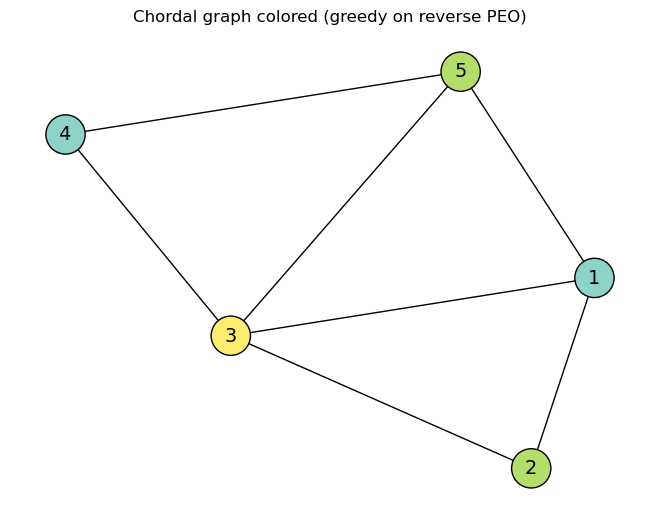

In [22]:
import matplotlib.pyplot as plt
import networkx as nx

def draw_coloring(G: nx.Graph, pos, coloring, title="Graph coloring"):
    colors = [coloring[v] for v in G.nodes()]
    nx.draw(
        G, pos,
        with_labels=True,
        node_size=800,
        font_size=14,
        node_color=colors,
        cmap=plt.cm.Set3,
        edgecolors="black"
    )
    plt.title(title)
    plt.axis("off")
    plt.show()

draw_coloring(G2, pos, coloring, title="Chordal graph colored (greedy on reverse PEO)")


## How we find a PEO for this graph

To color a chordal graph optimally, we first need a **perfect elimination ordering (PEO)**.  
Instead of guessing a PEO by hand, compute one using **Maximum Cardinality Search (MCS)**.

### Maximum Cardinality Search (MCS)

MCS builds an ordering by repeatedly choosing an unchosen vertex with the **largest label** (how many of v’s neighbors have already been chosen).

- Initially, every vertex has label 0.
- Repeatedly:
  1. Pick an unchosen vertex with the maximum label (ties can be broken arbitrarily).
  2. Append it to the MCS order.
  3. For every still-unchosen neighbor of that vertex, increase its label by 1.

the last vertices chosen by MCS behave like the first vertices of a valid elimination order (they are simplicial at the moment you eliminate them).

That is why we reverse the order gained from MCS to get PEO.

### Why we color in *reverse* PEO order

Once we have a PEO, we color using greedy coloring in reverse order. (In other words, in this implementation the greedy coloring order is the same as the original MCS selection order)

In a PEO, each vertex's **later neighbors** form a clique.
When we reverse the order, those "later neighbors" become the neighbors that are **already colored** when we process a vertex.
Because they form a clique, they all have different colors and they force exactly the minimum number of colors locally.
Greedy coloring then produces an **optimal** coloring for chordal graphs, using exactly `ω(G)` colors.


PEO found: [9, 12, 8, 7, 11, 6, 10, 5, 4, 3, 2, 1]
Number of colors used: 5
Maximum clique size ω(G3): 5


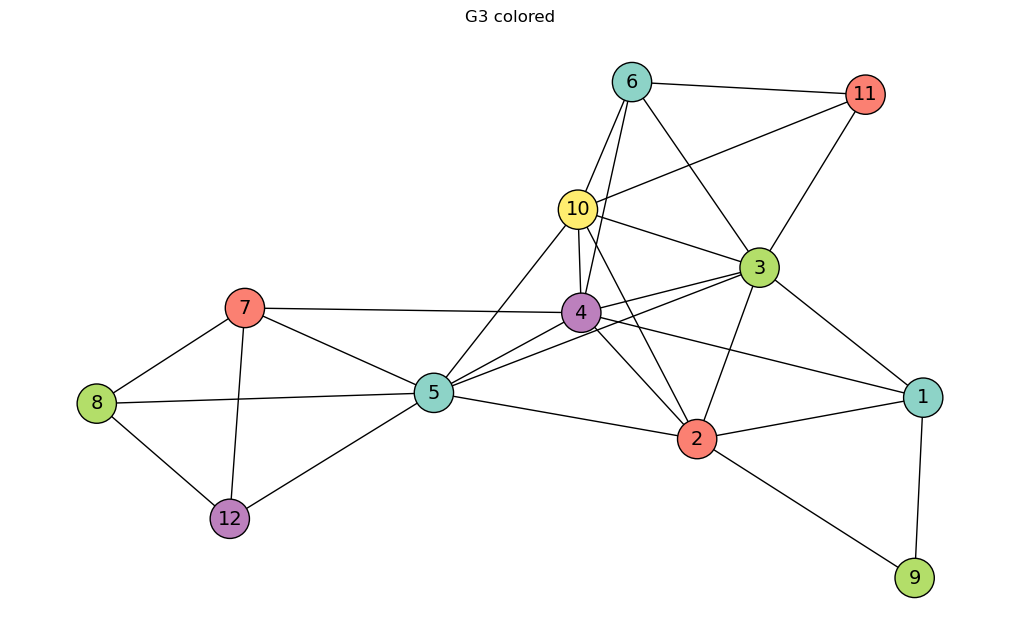

In [28]:
G3 = nx.Graph()

G3.add_edges_from([
    (1,2),(1,3),(1,4),
    (2,3),(2,4),
    (3,4)
])

G3.add_edges_from([(5,2),(5,3),(5,4)])
G3.add_edges_from([(6,3),(6,4)])

G3.add_edge(4, 5)
G3.add_edges_from([(7,4),(7,5)])

G3.add_edge(5, 7)
G3.add_edges_from([(8,5),(8,7)])

G3.add_edges_from([(9,1),(9,2)])

G3.add_edges_from([(10,2),(10,3),(10,5)])

G3.add_edge(6, 10)
G3.add_edges_from([(11,3),(11,6),(11,10)])

G3.add_edge(7, 8)
G3.add_edges_from([(12,5),(12,7),(12,8)])

G3.add_edge(4, 10) 

peo3, coloring3 = chordal_coloring(G3)
print("PEO found:", peo3)
print("Number of colors used:", num_colors(coloring3) if coloring3 else None)

omega3 = max((len(c) for c in nx.find_cliques(G3)), default=0)
print("Maximum clique size ω(G3):", omega3)

if coloring3 is None:
    print("Chordal coloring failed (graph not recognized as chordal by the code).")
else:
    pos3 = nx.kamada_kawai_layout(G3)

    plt.figure(figsize=(10, 6))
    draw_coloring(G3, pos3, coloring3, title="G3 colored")
